In [19]:
import os
import time
import torchaudio
import pandas as pd
from transformers import WhisperProcessor, WhisperForConditionalGeneration
from tqdm import tqdm
import matplotlib.pyplot as plt
import evaluate
import numpy as np
import language_tool_python

tool = language_tool_python.LanguageTool('pl')

def correct_polish_text(text):
    max_iterations = 3 
    for _ in range(max_iterations):
        matches = tool.check(text)
        if not matches:
            break
        corrected_parts = []
        last_pos = 0
        for match in matches:
            start = match.offset
            end = start + match.errorLength
            corrected_parts.append(text[last_pos:start])
            if match.replacements:
                corrected_parts.append(match.replacements[0])
            else:
                corrected_parts.append(text[start:end])
            last_pos = end
        corrected_parts.append(text[last_pos:])
        text = ''.join(corrected_parts)
    return text

metric = evaluate.load("wer")

def compute_metrics(pred, processor):
    pred_ids = pred["predictions"]
    label_ids = pred["label_ids"]
    label_ids[label_ids == -100] = processor.tokenizer.pad_token_id
    pred_str = processor.tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    label_str = processor.tokenizer.batch_decode(label_ids, skip_special_tokens=True)
    pred_str = [p.lower() for p in pred_str]
    label_str = [l.lower() for l in label_str]
    wer = 100 * metric.compute(predictions=pred_str, references=label_str)
    return {"eval_wer": wer}

def transcribe_samples(model, processor, samples, correct_text=False):
    results = []
    times = []
    predictions = []
    references = []
    wer_list = []

    for sample in tqdm(samples, desc=f"Transcribing Samples", unit="sample"):
        waveform, sample_rate = torchaudio.load(sample["file_path"])
        if sample_rate != processor.feature_extractor.sampling_rate:
            resampler = torchaudio.transforms.Resample(sample_rate, processor.feature_extractor.sampling_rate)
            waveform = resampler(waveform)
        input_features = processor(waveform.squeeze(0), sampling_rate=processor.feature_extractor.sampling_rate, return_tensors="pt").input_features

        reference_str = sample["reference"]

        start_time = time.time()
        pred_ids = model.generate(input_features)
        pred_str = processor.decode(pred_ids[0], skip_special_tokens=True)
        if correct_text:
            pred_str = correct_polish_text(pred_str)
        end_time = time.time()

        predictions.append(pred_str)
        references.append(reference_str)
        times.append(end_time - start_time)

        pred = {
            "predictions": processor.tokenizer(pred_str, return_tensors="pt", padding=True, truncation=True).input_ids,
            "label_ids": processor.tokenizer(reference_str, return_tensors="pt", padding=True, truncation=True).input_ids,
        }
        metrics = compute_metrics(pred, processor)
        wer_list.append(metrics["eval_wer"])

        results.append({"reference": reference_str, "transcription": pred_str})

    return results, times, wer_list, predictions, references

def evaluate_models(model_paths, samples, correct_text=False):
    results = {}
    times_all = {}
    wer_all = {}

    for model_path in model_paths:
        processor = WhisperProcessor.from_pretrained(model_path, language="pl", task="transcribe")
        model = WhisperForConditionalGeneration.from_pretrained(model_path)
        model.config.forced_decoder_ids = processor.get_decoder_prompt_ids(language="pl", task="transcribe")

        transcriptions, times, wer_list, predictions, references = transcribe_samples(model, processor, samples, correct_text)

        overall_pred = {
            "predictions": processor.tokenizer(predictions, padding=True, truncation=True, return_tensors="pt").input_ids,
            "label_ids": processor.tokenizer(references, padding=True, truncation=True, return_tensors="pt").input_ids,
        }
        overall_metrics = compute_metrics(overall_pred, processor)

        results[model_path] = overall_metrics["eval_wer"]
        times_all[model_path] = times
        wer_all[model_path] = wer_list

    return results, times_all, wer_all


def plot_wer_and_times(times_all_without, wer_all_without, times_all_with, wer_all_with):
    model_names = list(times_all_without.keys())

    fig, axes = plt.subplots(2, 1, figsize=(10, 10), gridspec_kw={'height_ratios': [2, 1]})

    x = np.arange(len(model_names))
    bar_width = 0.37

    wer_values_without = [wer_all_without[model_path] for model_path in model_names]
    avg_wer_without = [sum(wer) / len(wer) for wer in wer_values_without]

    wer_values_with = [wer_all_with[model_path] for model_path in model_names]
    avg_wer_with = [sum(wer) / len(wer) for wer in wer_values_with]

    bars_without = axes[0].bar(x - bar_width / 2, avg_wer_without, bar_width, label="Without Correction", color='orange')
    bars_with = axes[0].bar(x + bar_width / 2, avg_wer_with, bar_width, label="With Correction", color='green')

    axes[0].set_title("WER Comparison With and Without Correction", fontsize=14)
    axes[0].set_ylabel("WER (%)", fontsize=10)
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(model_names, rotation=45, fontsize=10)
    axes[0].legend()

    for bars, wer_values in zip([bars_without, bars_with], [avg_wer_without, avg_wer_with]):
        for bar, wer in zip(bars, wer_values):
            axes[0].text(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2, f'{wer:.2f}%', 
                         ha='center', va='center', fontsize=10, color='white')

    all_times_with = [times_all_with[model_path] for model_path in model_names]
    axes[1].boxplot(all_times_with, labels=model_names, patch_artist=True, boxprops=dict(facecolor="lightcoral"))
    axes[1].set_title("Inference Time With Correction", fontsize=14)
    axes[1].set_ylabel("Inference Time (s)", fontsize=12)
    axes[1].tick_params(axis='x', rotation=45, labelsize=10)

    plt.tight_layout()
    plt.show()


In [ ]:
audio_folder = "clips"
data = pd.read_csv("validated.tsv", sep="\t")
samples = []
for index, row in data.iterrows():
    file_path = os.path.join(audio_folder, row["path"])
    if os.path.exists(file_path):
        samples.append({"file_path": file_path, "reference": row["sentence"]})
        
model_folders = ["openai/whisper-tiny", "openai/whisper-base", "openai/whisper-small"]
model_folders.extend([folder_name for folder_name in os.listdir() if folder_name.startswith("whisper")])

results_without_correction, times_all_without_correction, wer_all_without_correction = evaluate_models(model_folders, samples, correct_text=False)

print("Correction part: ")
results_with_correction, times_all_with_correction, wer_all_with_correction = evaluate_models(model_folders, samples, correct_text=True)

C:\Users\kogut\AppData\Local\Temp\ipykernel_15440\3341183245.py:140: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot(all_times_with, labels=model_names, patch_artist=True, boxprops=dict(facecolor="lightcoral"))


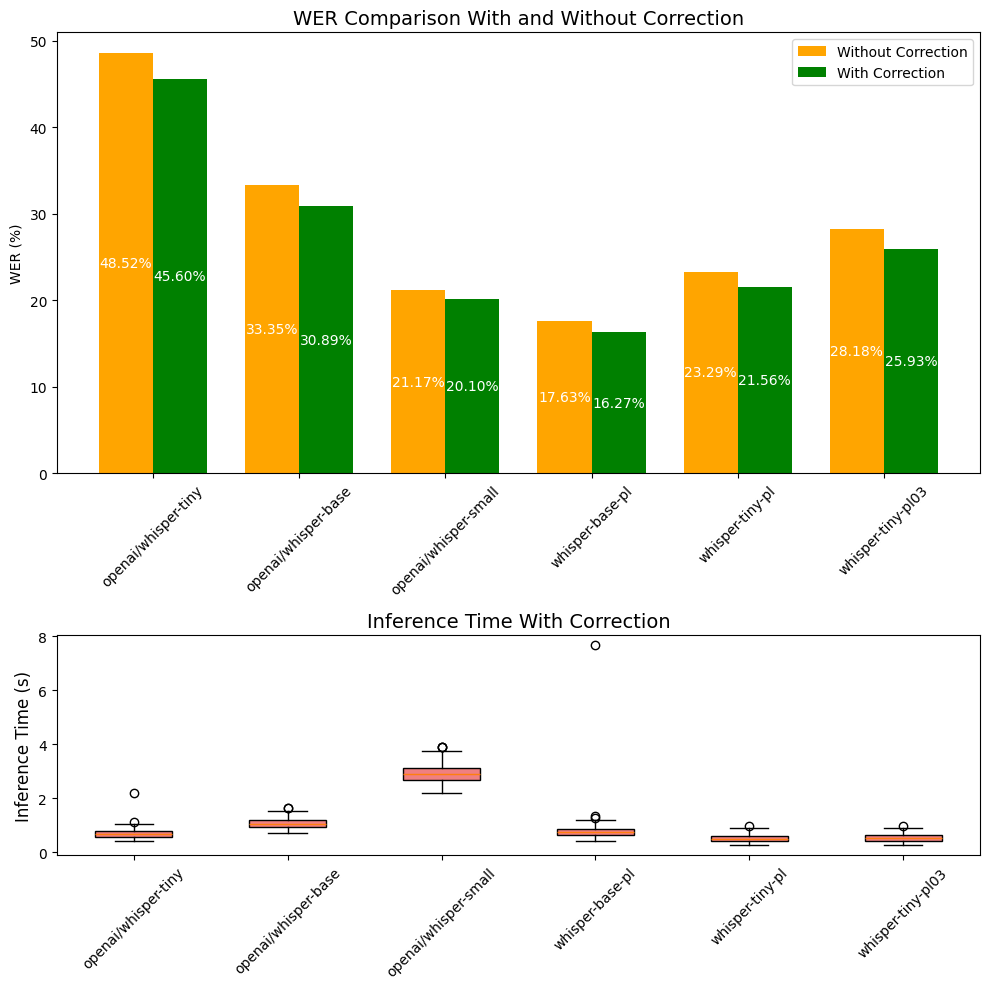

In [20]:
plot_wer_and_times(times_all_without_correction, wer_all_without_correction, 
                   times_all_with_correction, wer_all_with_correction)